PyCaret과 TPOT 간의 모델링 성능 비교

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from pycaret.classification import *

seed = 42
np.random.seed(seed)

In [2]:
df = pd.read_csv("/home/jovyan/work/_dataset/data_csv.csv")
df.head()

,CASE_NO_PATIENT'S,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,Global developmental delay/intellectual disability,Social/Behavioural Issues,Childhood Autism Rating Scale,Anxiety_disorder,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who_completed_the_test,ASD_traits
0,1,0,0,0,0,0,0,1,1,0,...,Yes,Yes,1,Yes,F,middle eastern,Yes,No,Family Member,No
1,2,1,1,0,0,0,1,1,0,0,...,Yes,Yes,2,Yes,M,White European,Yes,No,Family Member,Yes
2,3,1,0,0,0,0,0,1,1,0,...,Yes,Yes,4,Yes,M,Middle Eastern,Yes,No,Family Member,Yes
3,4,1,1,1,1,1,1,1,1,1,...,Yes,Yes,2,Yes,M,Hispanic,No,No,Family Member,Yes
4,5,1,1,0,1,1,1,1,1,1,...,Yes,Yes,1,Yes,F,White European,No,No,Family Member,Yes


In [3]:
df.drop("CASE_NO_PATIENT'S", axis=1, inplace=True) # 환자 ID 제거
df = df.dropna(axis=0)
df.isnull().sum()

A1                                                    0
A2                                                    0
A3                                                    0
A4                                                    0
A5                                                    0
A6                                                    0
A7                                                    0
A8                                                    0
A9                                                    0
A10_Autism_Spectrum_Quotient                          0
Social_Responsiveness_Scale                           0
Age_Years                                             0
Qchat_10_Score                                        0
Speech Delay/Language Disorder                        0
Learning disorder                                     0
Genetic_Disorders                                     0
Depression                                            0
Global developmental delay/intellectual disabili

In [4]:
# Ethnicity이 Asian, asian 이렇게 분리된 경우가 있어서 이를 통합
new_ethnicity = list(map(str.upper, df['Ethnicity'].to_list()))

# Who_completed_the_test 변수도 분리되어 있어서 이를 통합
new_who_completed = list(map(str.upper, df['Who_completed_the_test'].to_list()))

# dataset 생성
dataset = df.copy()

In [5]:
encoder = OrdinalEncoder()

# Ethnicity 변환
new_ethnicity = encoder.fit_transform(np.array(new_ethnicity).reshape(-1, 1))
dataset['Ethnicity'] = new_ethnicity

# Who_completed_the_test 변환
new_who_completed = encoder.fit_transform(np.array(new_who_completed).reshape(-1, 1))
dataset['Who_completed_the_test'] = new_who_completed

In [6]:
yes_no_columns = ['Social_Responsiveness_Scale', 'Speech Delay/Language Disorder', 'Learning disorder', 'Genetic_Disorders', 'Depression', 'Global developmental delay/intellectual disability', 'Social/Behavioural Issues', 'Anxiety_disorder', 'Jaundice', 'Family_mem_with_ASD', 'ASD_traits']

for column in yes_no_columns:
    dataset[column] = dataset[column].replace({'Yes': 1.0, 'No': 0.0})

# 성별 수치형 변환
dataset['Sex'] = dataset['Sex'].replace({'M': 0.0, 'F': 1.0})

In [7]:
dataset.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10_Autism_Spectrum_Quotient,...,Global developmental delay/intellectual disability,Social/Behavioural Issues,Childhood Autism Rating Scale,Anxiety_disorder,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who_completed_the_test,ASD_traits
0,0,0,0,0,0,0,1,1,0,1,...,1.0,1.0,1,1.0,1.0,4.0,1.0,0.0,0.0,0.0
1,1,1,0,0,0,1,1,0,0,0,...,1.0,1.0,2,1.0,0.0,10.0,1.0,0.0,0.0,1.0
2,1,0,0,0,0,0,1,1,0,1,...,1.0,1.0,4,1.0,0.0,4.0,1.0,0.0,0.0,1.0
3,1,1,1,1,1,1,1,1,1,1,...,1.0,1.0,2,1.0,0.0,2.0,0.0,0.0,0.0,1.0
4,1,1,0,1,1,1,1,1,1,1,...,1.0,1.0,1,1.0,1.0,10.0,0.0,0.0,0.0,1.0


In [8]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:, -1]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42)

In [10]:
from tpot import TPOTClassifier

# TPOT
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=1, random_state=42)
tpot.fit(X_train, y_train)

print(tpot.score(X_test, y_test))



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: RandomForestClassifier(MinMaxScaler(input_matrix), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=8, min_samples_split=4, n_estimators=100)
1.0


In [11]:
train = X_train.copy()
train['ASD_traits'] = y_train

test = X_test.copy()
test['ASD_traits'] = y_test

In [12]:
# PyCaret
clf = setup(data=train, target='ASD_traits', test_data=test, session_id=seed, verbose=0)
best_model = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0530
gbc,Gradient Boosting Classifier,0.9993,1.0000,1.0000,0.9987,0.9993,0.9986,0.9986,0.0380
xgboost,Extreme Gradient Boosting,0.9993,1.0000,1.0000,0.9987,0.9993,0.9986,0.9986,0.0210
lightgbm,Light Gradient Boosting Machine,0.9979,1.0000,0.9987,0.9974,0.9980,0.9958,0.9959,0.5390
dt,Decision Tree Classifier,0.9938,0.9939,0.9907,0.9974,0.9940,0.9875,0.9876,0.0290
ada,Ada Boost Classifier,0.9910,0.9997,0.9921,0.9908,0.9914,0.9819,0.9820,0.0220
et,Extra Trees Classifier,0.9903,0.9997,0.9974,0.9845,0.9908,0.9805,0.9808,0.0430
lr,Logistic Regression,0.9605,0.9833,0.9604,0.9644,0.9622,0.9208,0.9212,0.2980
knn,K Neighbors Classifier,0.9508,0.9852,0.9523,0.9538,0.9530,0.9013,0.9015,0.0160
lda,Linear Discriminant Analysis,0.9147,0.9681,0.8796,0.9542,0.9149,0.8297,0.8332,0.0070


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

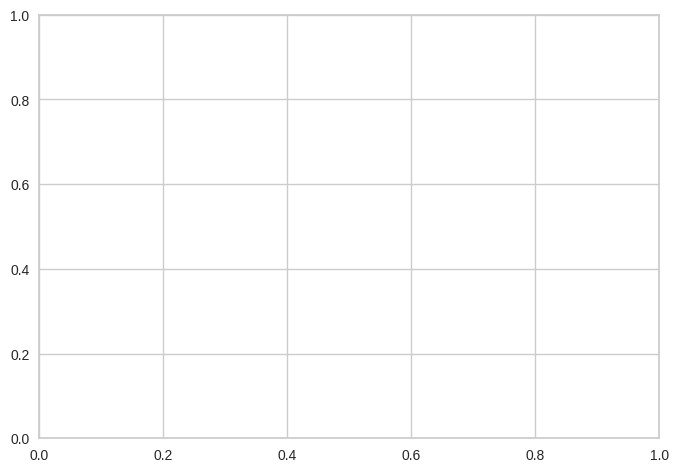

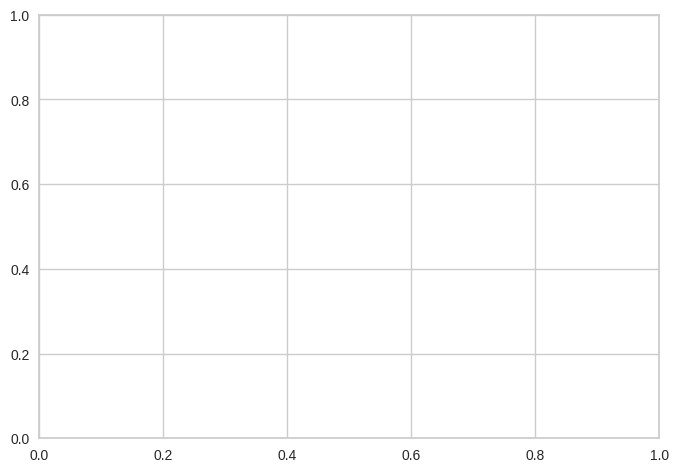

In [15]:
evaluate_model(best_model)